In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths

import os

import torch
import torch.utils.data
from opts import opts
from models.model import create_model, load_model, save_model
from models.data_parallel import DataParallel
from logger import Logger
from datasets.dataset_factory import get_dataset
from trains.train_factory import train_factory
import cv2
import sys
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
sys.argv = ['-f', 'ctdetv2', '--exp_id', 'coco_dlav6','--num_workers', '0','--batch_size','2', '--arch','dlav6_34',  '--load_model' ,'../exp/ctdetv2/coco_dlav6/model_last.pth'] #cmd = 'ctdet --exp_id coco_dla --batch_size 4 --lr 1.25e-4  --gpus 0 --num_workers 0'
opt = opts().parse()
print(opt.task)
print(opt.num_workers)
print(opt.batch_size)

Fix size testing.
training chunk_sizes: [2]
The output will be saved to  C:\Users\avata\FewShot-CenterNet\src\lib\..\..\exp\ctdetv2\coco_dlav6
ctdetv2
0
2


In [4]:
torch.manual_seed(opt.seed)
torch.backends.cudnn.benchmark = not opt.not_cuda_benchmark and not opt.test

In [5]:
Dataset = get_dataset(opt.dataset, opt.task)
opt = opts().update_dataset_info_and_set_heads(opt, Dataset)
logger = Logger(opt)
os.environ['CUDA_VISIBLE_DEVICES'] = opt.gpus_str
opt.device = torch.device('cuda' if opt.gpus[0] >= 0 else 'cpu')

heads {'hm': 80, 'wh': 2, 'reg': 2}


In [6]:
model = create_model(opt.arch, opt.heads, opt.head_conv)
optimizer = torch.optim.Adam(model.parameters(), opt.lr)
start_epoch = 0
if opt.load_model != '':
    model, optimizer, start_epoch = load_model(model, opt.load_model, optimizer, opt.resume, opt.lr, opt.lr_step)

loaded ../exp/ctdetv2/coco_dlav6/model_last.pth, epoch 12


In [7]:
Trainer = train_factory[opt.task]
trainer = Trainer(opt, model, optimizer)
trainer.set_device(opt.gpus, opt.chunk_sizes, opt.device)

In [8]:
train_loader = torch.utils.data.DataLoader(
      Dataset(opt, 'train'), 
      batch_size=opt.batch_size, 
      shuffle=True,
      num_workers=opt.num_workers,
      pin_memory=True,
      drop_last=True
  )

==> initializing coco 2017 train data.
loading annotations into memory...
Done (t=13.60s)
creating index...
index created!
Loaded train 118287 samples


In [52]:
img = next(iter(train_loader))

In [53]:
print(img.keys())
print(img['input'].size())

dict_keys(['input', 'hm', 'reg_mask', 'ind', 'wh', 'hm_mod', 'reg'])
torch.Size([2, 3, 512, 512])


In [54]:
model.to('cuda')
torch.cuda.empty_cache()
outputs = model(img['input'].to('cuda'))
output = outputs[0]
print(output.keys())

dict_keys(['objns', 'hm', 'wh', 'reg'])


In [55]:
batch=img
mask = batch['reg_mask']
ind = batch['ind']
target_wh = batch['wh']
target_reg = batch['reg']

In [56]:
pred_hm = output['hm'].sigmoid()
print(pred_hm.size())
gt_hm = batch['hm']
print(gt_hm.size())

torch.Size([2, 80, 128, 128])
torch.Size([2, 80, 128, 128])


C heatmaps summed
torch.Size([2, 80, 128, 128])
tensor(0.6831, device='cuda:0', grad_fn=<MaxBackward1>)


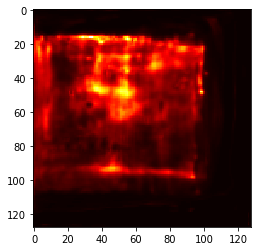

In [71]:
print('C heatmaps summed')
img_gt2 = pred_hm.detach().cpu().numpy()
img = img_gt2[1,7,:,:]
print(pred_hm.size())
print(pred_hm.max())
plt.imshow(img, cmap='hot', interpolation='nearest')

C heatmaps summed


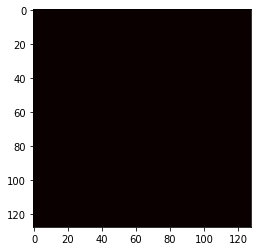

In [72]:
print('C heatmaps summed')
plt.imshow(gt_hm[1,7,:,:].detach().cpu().numpy(), cmap='hot', interpolation='nearest')

In [63]:
mask

tensor([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.uint8)